In [ ]:
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

In [ ]:
# Load datasets
true_data_url = "https://raw.githubusercontent.com/Siddhartha15/Hindi-Fake-News-Detection/main/Data/true_news.csv"
fake_data_url = "https://raw.githubusercontent.com/Siddhartha15/Hindi-Fake-News-Detection/main/Data/fake_news.csv"

true_data = pd.read_csv(true_data_url, sep=',', header=None)
fake_data = pd.read_csv(fake_data_url, sep=',', header=None)


# Rename columns
true_data.columns = ['id', 'short_description', 'full_title', 'long_description']
fake_data.columns = ['id', 'short_description', 'full_title', 'long_description']

# Combine text columns
true_data['news'] = true_data['short_description'] + " " + true_data['full_title'] + " " + true_data['long_description']
fake_data['news'] = fake_data['short_description'] + " " + fake_data['full_title'] + " " + fake_data['long_description']

# Add labels
true_data['label'] = 'True'
fake_data['label'] = 'Fake'

# Keep necessary columns
true_data = true_data[['news', 'label']]
fake_data = fake_data[['news', 'label']]

# Combine datasets
new_data = pd.concat([true_data, fake_data], ignore_index=True)

new_data = new_data.sample(frac=1, random_state=42).reset_index(drop=True)
# Map labels
new_data['label'] = new_data['label'].map({'Fake': 1, 'True': 0})

# Drop NaN values
new_data.dropna(subset=['label'], inplace=True)

print(new_data.head(20))

                                                 news  label
0   अंतिम चरण के मतदान दिन पहल सोशल मीडिय बड़ तैया...      1
1   बूम पाय तस्वीर स्वर्गीय एक्टर पुष्प जोश 2018 फ...      1
2   हालांक अतीत ऐश्वर्य राय बच्चन टिप्पण दी विशेष ...      1
3   किसान के रोष के चल हरियाण सियासत बड़ हलचल शुर ...      0
4   दिल्ल के परिवहन विभाग कार के हाई सिक्योरिट रजि...      0
5   दाव तस्वीर दिख करीब 250 मिलियन लोग किसान आंदोल...      1
6   बूम पाय सिंध सरकार क्वारंटाइन फैसिलिट ईरान पाक...      1
7   बूम पाय वायरल तस्वीर काश प्रांत बीजेप युव मोर्...      1
8   कार्यकर् कवि कृष्णन फेसबुक पेज ‘I am with Bark...      1
9   फ़ेसबुक जोर शोर वायरल वीडिय फ़र्ज़ दाव रह तीन हज़ा...      1
10  डोनाल्ड ट्रम्प कार्बनकॉप डेनिस एलन मंचन वर्ष श...      1
11  बूम पाय क्लिप 2019 के यूट्यूब वेबसीरीज क्रॉप  ...      1
12  प्रसार भार ची विदेश मंत्रालय पूछ भारत जम्मू-कश...      0
13  सोशल मीडिय मोद जोड़ ऐस बयान वायरल किय रह तस्वीर...      1
14  बूम पाय दोन तस्वीर एडिट किय गय है। पेशाब ना नि...      1
15  नए कृष क़ानून आरएसएस

In [ ]:
new_data = new_data.rename(columns={'label': 'Label', 'news': 'News'})
print(new_data.head())

                                                News  Label
0  अंतिम चरण के मतदान दिन पहल सोशल मीडिय बड़ तैया...      1
1  बूम पाय तस्वीर स्वर्गीय एक्टर पुष्प जोश 2018 फ...      1
2  हालांक अतीत ऐश्वर्य राय बच्चन टिप्पण दी विशेष ...      1
3  किसान के रोष के चल हरियाण सियासत बड़ हलचल शुर ...      0
4  दिल्ल के परिवहन विभाग कार के हाई सिक्योरिट रजि...      0


In [ ]:
# Preprocess text
def clean_text(text):
    text = str(text)  # Ensure text is a string
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\d+', '', text)  # Remove digits
    text = text.strip()  # Remove leading/trailing whitespace
    return text

new_data['Cleaned_News'] = new_data['News'].apply(clean_text)


In [ ]:
# Load additional datasets
train_file_path = '/content/train_Hindi_Data_Complete_FakeNews.txt'
test_file_path = '/content/test_Hindi_Data_Complete_FakeNews.txt'

columns = ['Domain', 'Topic', 'News', 'Label']

t_data = pd.read_csv(train_file_path, sep='\t', names=columns, encoding='utf-8')
te_data = pd.read_csv(test_file_path, sep='\t', names=columns, encoding='utf-8')

train_data = t_data.drop(['Domain', 'Topic'], axis=1)


test_data = te_data.drop(['Domain', 'Topic'], axis=1)

# Map labels for train and test data
train_data['Label'] = train_data['Label'].map({'Fake': 1, 'Legit': 0})
test_data['Label'] = test_data['Label'].map({'Fake': 1, 'Legit': 0})

# Drop NaN values in train and test data
train_data.dropna(subset=['Label'], inplace=True)
test_data.dropna(subset=['Label'], inplace=True)

#  Replace NaN values with 0 before converting to int
train_data['Label'] = train_data['Label'].fillna(0).astype(int)
test_data['Label'] = test_data['Label'].fillna(0).astype(int)

print(train_data.head())
print(test_data.head())


                                                News  Label
1  रोजर फेडरर ने मियामी ओपन में अपने तीन साल के प...      0
2  सील और हेदी क्लम ने जोर देकर कहा अपने अलग होने...      1
3  हैरी स्टाइल्स का नया संगीत सभी के लिए नहीं है,...      1
4  कंजर्वेटिव डार्लिंग-परिया तोमी लाह्रेन महिलाओं...      0
5  जैसे आपको पता नहीं था कि बियॉन्से इसे बंद करने...      0
                                                News  Label
1  जिम कैरी ने फैशन ईक पार्टी में रोस्ट फैशन ईक प...      0
2  वाशिंगटन (CNN) इंटेलिजेंस ने हाल के हफ्तों में...      0
3  वेस्टबोरो बैपटिस्ट की तरह, ऑरलैंडो बैप्टिस्ट स...      1
4  विवादास्पद रियलिटी टीवी स्टार वास्तव में अपनी ...      1
5  विल स्मिथ द फ्रेश प्रिंस ऑफ बेल-एयर के कलाकारो...      1


In [ ]:
# Clean text for train and test data
train_data['Cleaned_News'] = train_data['News'].apply(clean_text)
test_data['Cleaned_News'] = test_data['News'].apply(clean_text)

# Combine all datasets
combined_data = pd.concat([train_data[['Cleaned_News', 'Label']],
                           test_data[['Cleaned_News', 'Label']],
                           new_data[['Cleaned_News', 'Label']]],
                          ignore_index=True)

# Check for NaN values
print("NaN values in combined dataset:", combined_data.isna().sum())


NaN values in combined dataset: Cleaned_News    0
Label           0
dtype: int64


In [ ]:
# Split dataset into training and testing sets
X = combined_data['Cleaned_News']
y = combined_data['Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
len(X_train),len(y_train),len(X_test),len(y_test)

(2129, 2129, 533, 533)

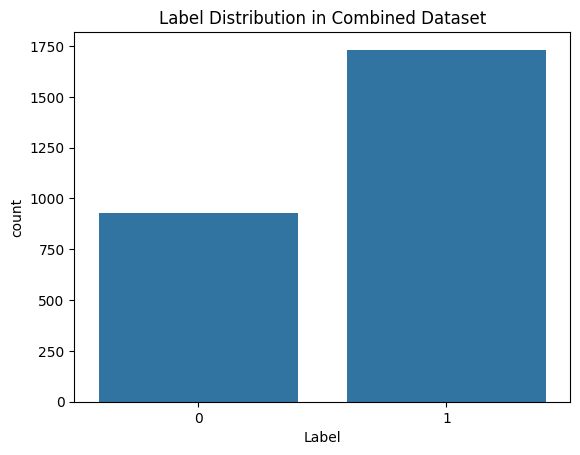

In [ ]:
# Visualize label distribution
sns.countplot(x='Label', data=combined_data)
plt.title('Label Distribution in Combined Dataset')
plt.show()

In [ ]:
!python -m nltk.downloader stopwords

/usr/lib/python3.10/runpy.py:126: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
from nltk.corpus import stopwords

try:
    hindi_stopwords = set(stopwords.words('hindi'))
    print("Hindi stopwords loaded successfully!")
except Exception as e:
    print("Error:", e)

Error: No such file or directory: '/root/nltk_data/corpora/stopwords/hindi'


In [ ]:
hindi_stopwords = {
    'अत','अपना','अपनी','अपने','अभी','अंदर','आदि','आप','इत्यादि','इन','इनका','इन्हीं','इन्हें','इन्हों','इस','इसका','इसकी','इसके','इसमें',
'इसी','इसे','उन','उनका','उनकी','उनके','उनको','उन्हीं','उन्हें','उन्हों','उस','उसके','उसी','उसे','एक','एवं','एस','ऐसे','और','कई',
'कर','करता','करते','करना','करने','करें','कहते','कहा','का','काफ़ी','कि','कितना','किन्हें','किन्हों','किया','किर','किस','किसी','किसे','की',
'कुछ','कुल','के','को','कोई','कौन','कौन','बही','बहुत','बाद','बाला','बिलकुल','भी','भीतर','मगर','मानो','मे','में','यदि','यह','यहाँ','यही',
'या','यिह','ये','रखें','रहा','रहे','ऱ्वासा','लिए','लिये','लेकिन','व','वग़ैरह','वर्ग','वह','वहाँ','वहीं','वाले','वुह','वे','सकता','सकते','सबसे',
'सभी','साथ','साबुत','साभ','सारा','से','सो','संग','ही','हुआ','हुई','हुए','है','हैं','हो','होता','होती','होते','होना','होने','पर', 'इन', 'वह', 'यिह', 'वुह', 'जिन्हें', 'जिन्हों', 'तिन्हें', 'तिन्हों',
    'किन्हों', 'किन्हें', 'इत्यादि', 'द्वारा', 'इन्हें', 'इन्हों', 'उन्हों', 'बिलकुल',
    'निहायत', 'ऱ्वासा', 'इन्हीं', 'उन्हीं', 'उन्हें', 'इसमें', 'जितना', 'दुसरा',
    'कितना', 'दबारा', 'साबुत', 'वग़ैरह', 'दूसरे', 'कौनसा', 'लेकिन', 'होता',
    'करने', 'किया', 'लिये', 'अपने', 'नहीं', 'दिया', 'इसका', 'करना', 'वाले',
    'सकते', 'इसके', 'सबसे', 'होने', 'करते', 'बहुत', 'वर्ग', 'करें', 'होती',
    'अपनी', 'उनके', 'कहते', 'होते', 'करता', 'उनकी', 'इसकी', 'सकता', 'रखें',
    'अपना', 'उसके', 'जिसे', 'तिसे', 'किसे', 'किसी', 'काफ़ी', 'पहले', 'नीचे',
    'बाला', 'यहाँ', 'जैसा', 'जैसे', 'मानो', 'अंदर', 'भीतर', 'पूरा', 'सारा',
    'होना', 'उनको', 'वहाँ', 'वहीं', 'जहाँ', 'जीधर', 'उनका', 'इनका', 'के',
    'हैं', 'गया', 'बनी', 'एवं', 'हुआ', 'साथ', 'बाद', 'लिए', 'कुछ', 'कहा',
    'यदि', 'हुई', 'इसे', 'हुए', 'अभी', 'सभी', 'कुल', 'रहा', 'रहे', 'इसी',
    'उसे', 'जिस', 'जिन', 'तिस', 'तिन', 'कौन', 'किस', 'कोई', 'ऐसे', 'तरह',
    'किर', 'साभ', 'संग', 'यही', 'बही', 'उसी', 'फिर', 'मगर', 'का', 'एक',
    'यह', 'से', 'को', 'इस', 'कि', 'जो', 'कर', 'मे', 'ने', 'तो', 'ही', 'या',
    'हो', 'था', 'तक', 'आप', 'ये', 'थे', 'दो', 'वे', 'थी', 'जा', 'ना', 'उस',
    'एस', 'पे', 'उन', 'सो', 'भी', 'और', 'घर', 'तब', 'जब', 'अत', 'व', 'न'
}

In [ ]:
def clean_text(text):
    text = str(text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    text = text.strip()
    # Remove stopwords
    text = ' '.join(word for word in text.split() if word not in hindi_stopwords)
    return text

# Apply the updated clean_text function
combined_data['Cleaned_News'] = combined_data['Cleaned_News'].apply(clean_text)

In [ ]:
# Feature extraction using TF-IDF
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_tfidf = tfidf.fit_transform(X_train).toarray()
X_test_tfidf = tfidf.transform(X_test).toarray()


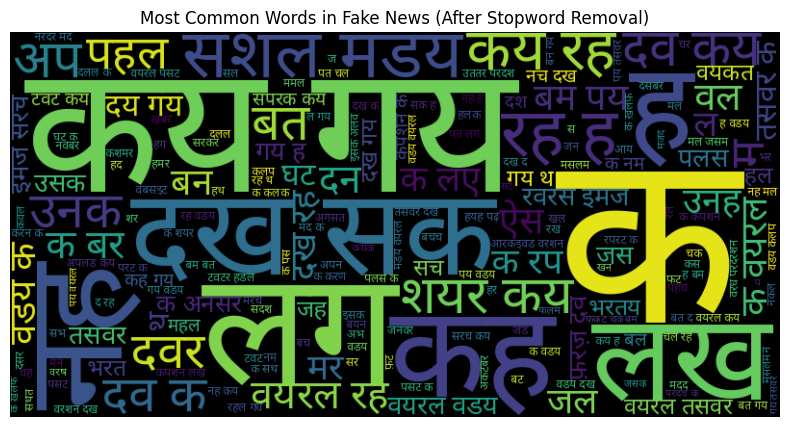

In [ ]:
# Generate a new WordCloud for Fake News
fake_news_text = ' '.join(combined_data[combined_data['Label'] == 1]['Cleaned_News'])
wordcloud_fake = WordCloud(
    font_path='/content/NotoSansDevanagari-Regular.ttf',
    width=800, height=400, background_color='black'
).generate(fake_news_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_fake, interpolation='bilinear')
plt.title('Most Common Words in Fake News (After Stopword Removal)')
plt.axis('off')
plt.show()


In [ ]:
print("NaN in y_train:", y_train.isnull().sum())
print("NaN in y_test:", y_test.isnull().sum())


NaN in y_train: 0
NaN in y_test: 0


In [ ]:
# Define features and labels
X = combined_data['Cleaned_News']
y = combined_data['Label']

# Split data again
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

Model: Logistic Regression
Accuracy: 0.8311444652908068
              precision    recall  f1-score   support

           0       0.74      0.70      0.72       166
           1       0.87      0.89      0.88       367

    accuracy                           0.83       533
   macro avg       0.80      0.80      0.80       533
weighted avg       0.83      0.83      0.83       533

--------------------------------------------------


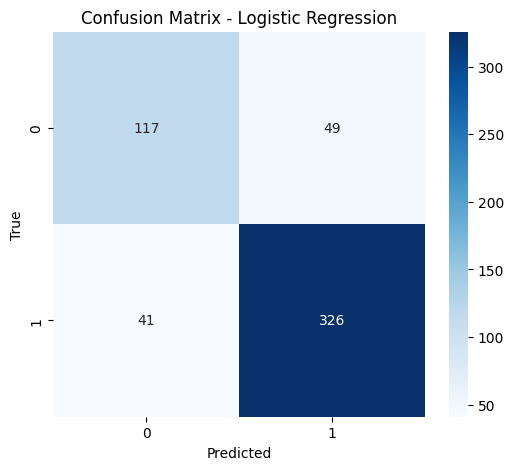

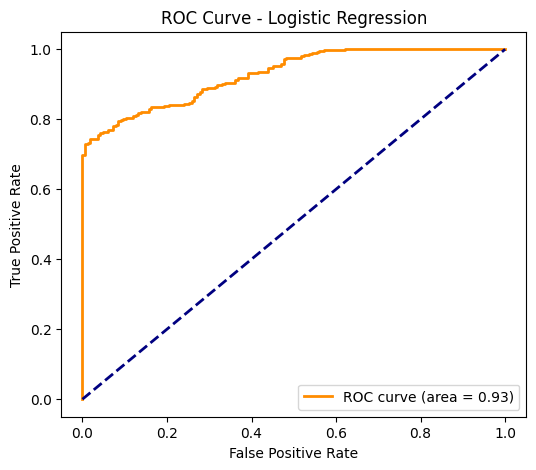

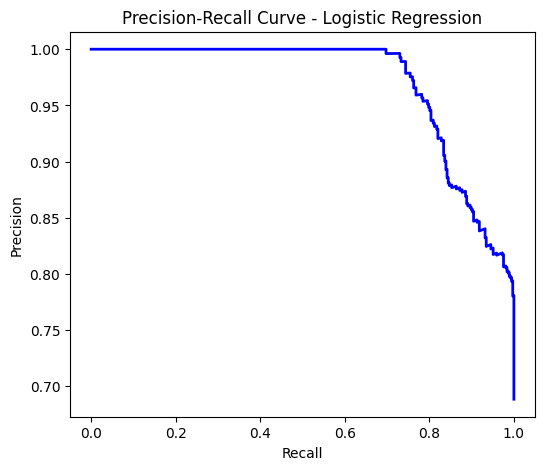

Model: Random Forest
Accuracy: 0.8574108818011257
              precision    recall  f1-score   support

           0       0.76      0.78      0.77       166
           1       0.90      0.89      0.90       367

    accuracy                           0.86       533
   macro avg       0.83      0.84      0.83       533
weighted avg       0.86      0.86      0.86       533

--------------------------------------------------


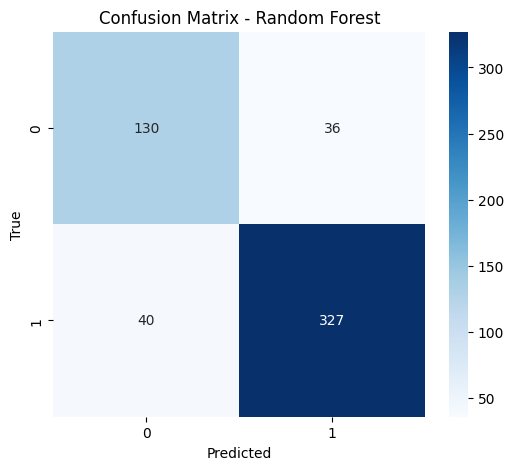

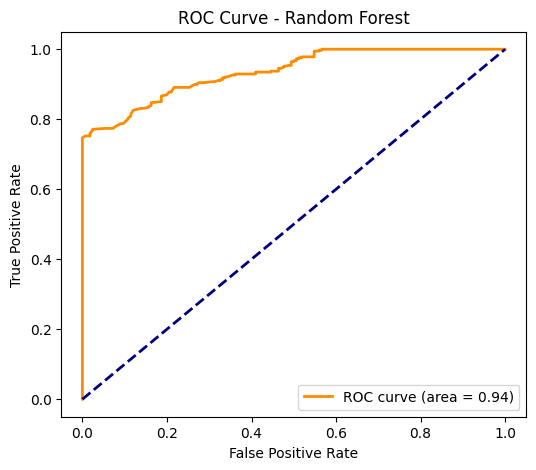

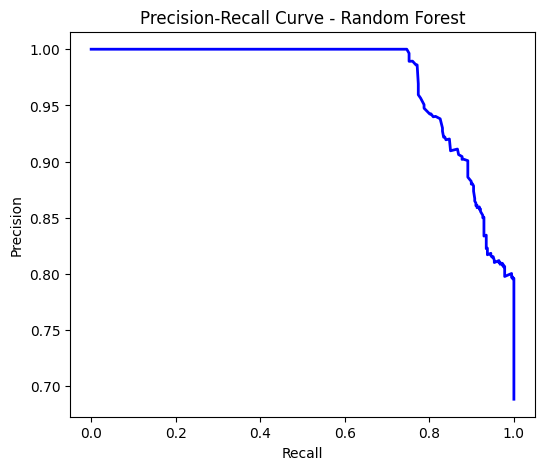

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2311 (\N{DEVANAGARI LETTER I}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Matplotlib currently does not support Devanagari natively.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2350 (\N{DEVANAGARI LETTER MA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2332 (\N{DEVANAGARI LETTER JA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2309 (\N{DEVANAGARI LETTER A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/

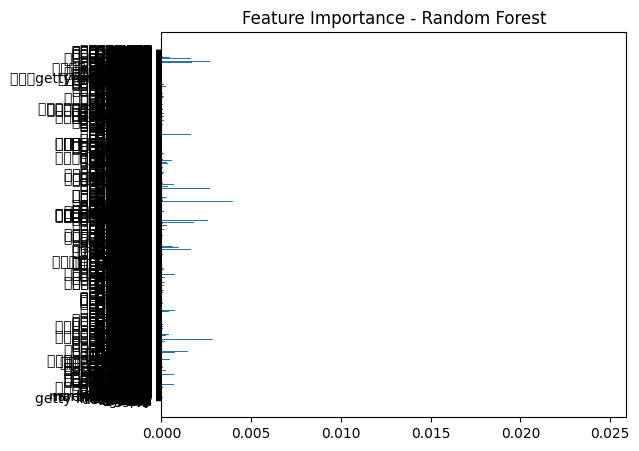

Model: SVM
Accuracy: 0.8273921200750469
              precision    recall  f1-score   support

           0       0.71      0.75      0.73       166
           1       0.89      0.86      0.87       367

    accuracy                           0.83       533
   macro avg       0.80      0.81      0.80       533
weighted avg       0.83      0.83      0.83       533

--------------------------------------------------


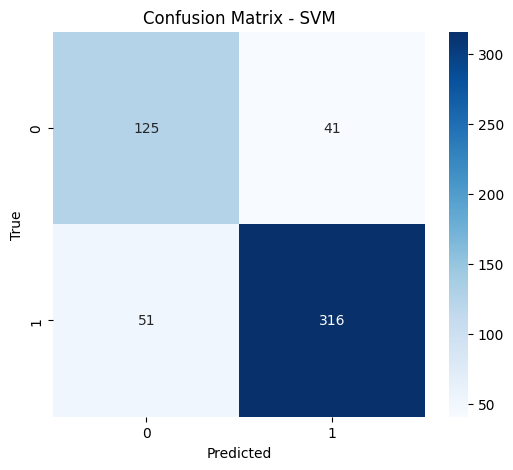

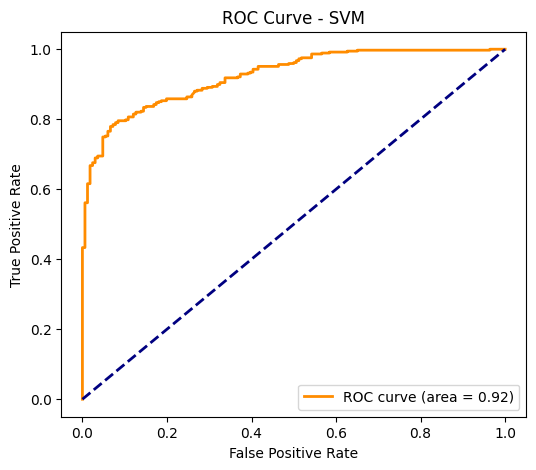

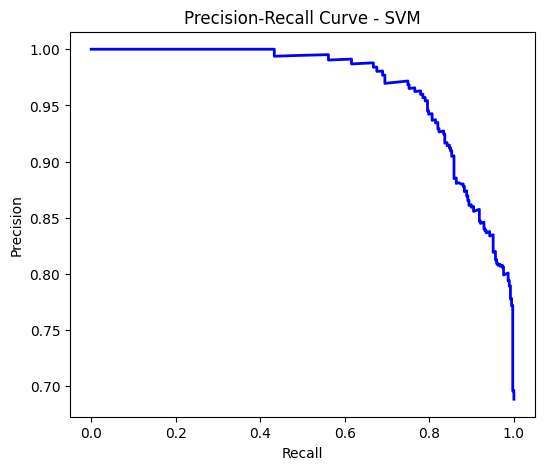

Model: K-Nearest Neighbors
Accuracy: 0.324577861163227
              precision    recall  f1-score   support

           0       0.32      1.00      0.48       166
           1       1.00      0.02      0.04       367

    accuracy                           0.32       533
   macro avg       0.66      0.51      0.26       533
weighted avg       0.79      0.32      0.18       533

--------------------------------------------------


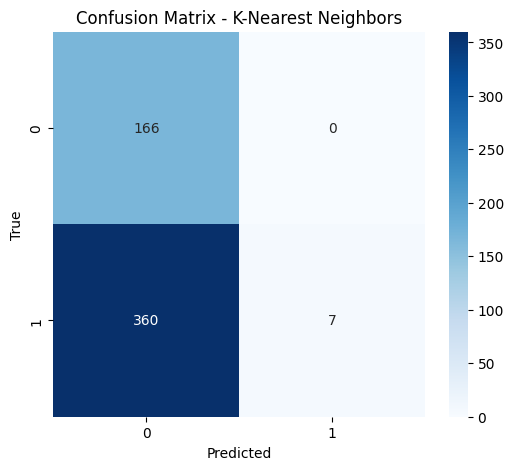

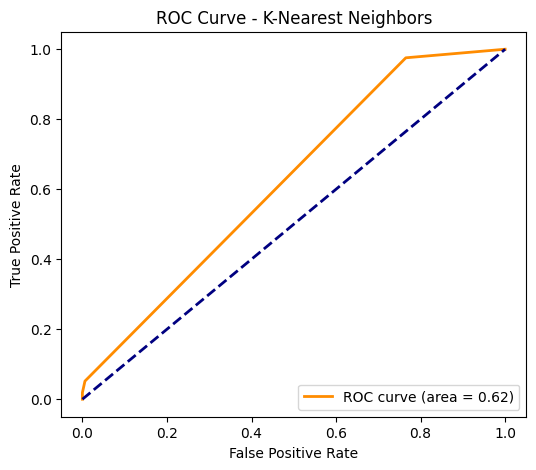

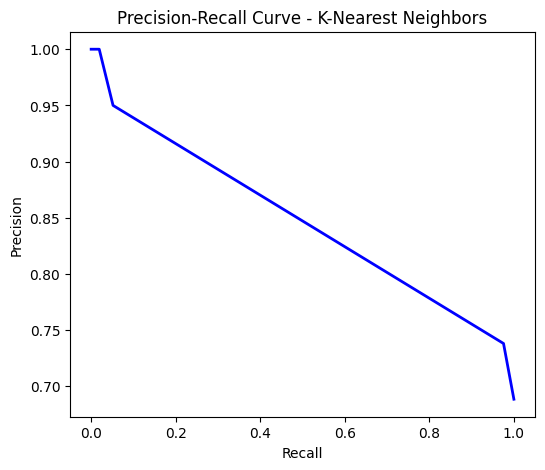

Model: Decision Tree
Accuracy: 0.801125703564728
              precision    recall  f1-score   support

           0       0.67      0.70      0.69       166
           1       0.86      0.84      0.85       367

    accuracy                           0.80       533
   macro avg       0.77      0.77      0.77       533
weighted avg       0.80      0.80      0.80       533

--------------------------------------------------


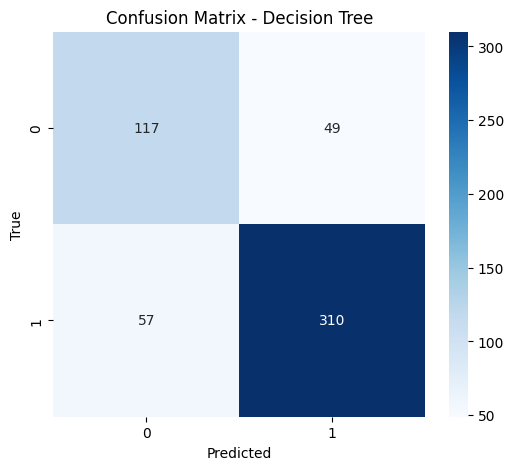

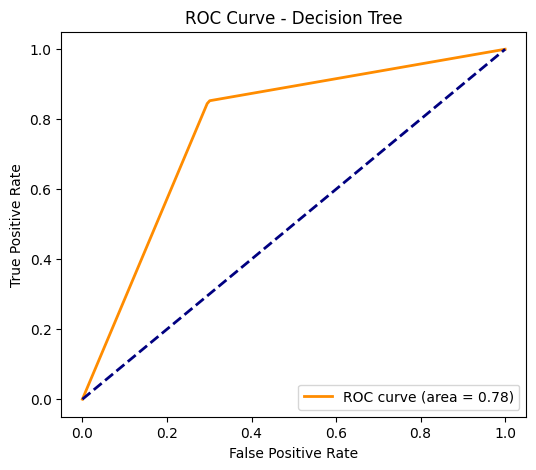

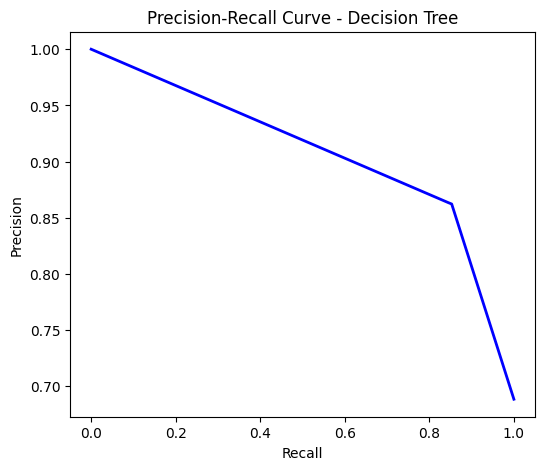

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2311 (\N{DEVANAGARI LETTER I}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Matplotlib currently does not support Devanagari natively.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2350 (\N{DEVANAGARI LETTER MA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2332 (\N{DEVANAGARI LETTER JA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2309 (\N{DEVANAGARI LETTER A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/

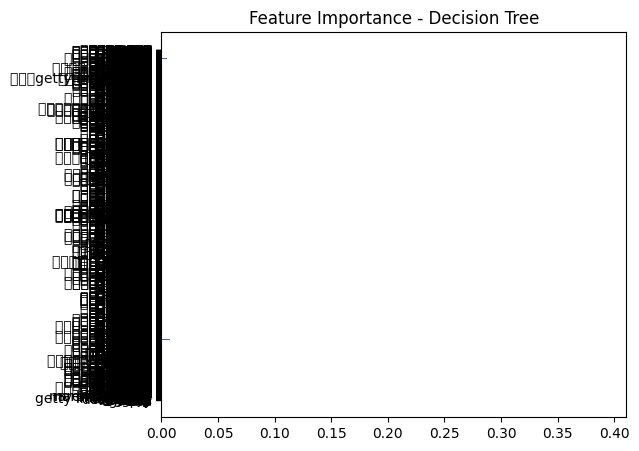

Model: Naive Bayes
Accuracy: 0.8123827392120075
              precision    recall  f1-score   support

           0       0.65      0.85      0.74       166
           1       0.92      0.80      0.85       367

    accuracy                           0.81       533
   macro avg       0.79      0.82      0.80       533
weighted avg       0.84      0.81      0.82       533

--------------------------------------------------


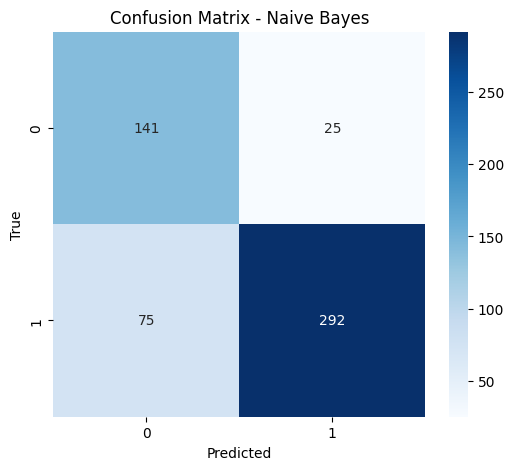

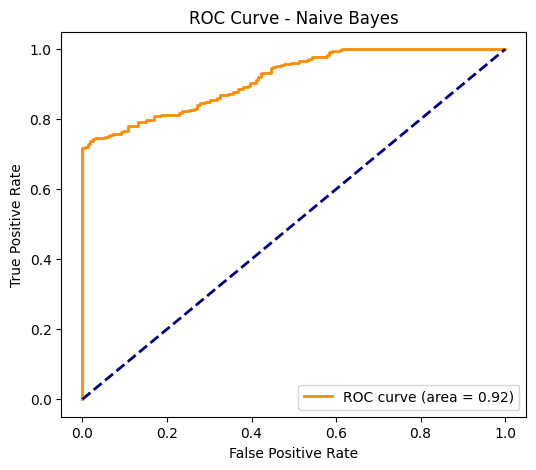

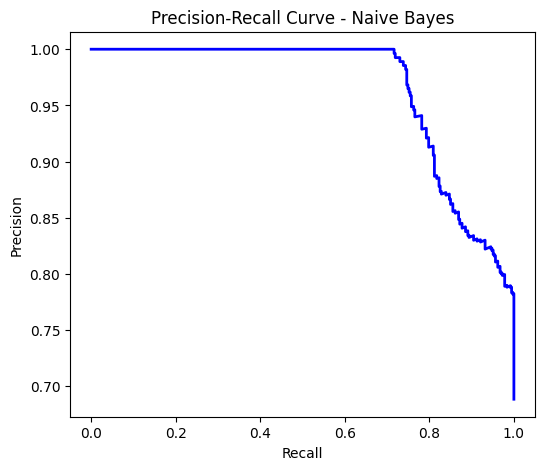

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns

# Define models
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(kernel='linear', probability=True, random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Naive Bayes': MultinomialNB()
}

# Train and evaluate models
for name, model in models.items():
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)

    # Accuracy and Classification Report
    print(f"Model: {name}")
    print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
    print(classification_report(y_test, y_pred))
    print("-" * 50)

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # ROC Curve (for classifiers with probability prediction)
    if hasattr(model, "predict_proba"):
        y_probs = model.predict_proba(X_test_tfidf)[:, 1]  # probability for the positive class
        fpr, tpr, _ = roc_curve(y_test, y_probs)
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=(6, 5))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.title(f'ROC Curve - {name}')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc='lower right')
        plt.show()

        # Precision-Recall Curve
        precision, recall, _ = precision_recall_curve(y_test, y_probs)
        plt.figure(figsize=(6, 5))
        plt.plot(recall, precision, color='b', lw=2)
        plt.title(f'Precision-Recall Curve - {name}')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.show()

    # Feature Importance (only for tree-based models)
    if hasattr(model, 'feature_importances_'):
        feature_importances = model.feature_importances_
        plt.figure(figsize=(6, 5))
        plt.barh(range(len(feature_importances)), feature_importances, align='center')
        plt.yticks(range(len(feature_importances)), tfidf.get_feature_names_out()) # Use tfidf.get_feature_names_out() to get feature names
        plt.title(f'Feature Importance - {name}')
        plt.show()
